# Urban area mapping using Sentinel 1 data

* **Products used:** 
[s1_rtc](https://explorer.digitalearth.africa/products/s1_rtc), 

## Background

Urban areas account for a small proportion of global land cover, but support daily human life and exert a great influence on environmental and ecological changes [Xia et al. 2019](https://doi.org/10.3390/rs11121470). 
This means that constant monitoring of the built environment is crucial for sustainable development. 
There are different techniques used to classify urban areas using both optical and radar data. 
The simplest techniques are image thresholding (rule-based classification) and Kmeans clustering (unsupervised machine learning). 

While urban areas can be mapped using optical data, the image quality is strongly affected by weather conditions such as cloud cover. 
This limits the temporal avaliability of clear images in tropical areas that experience very cloudy weather and heavy rains. 
The image quality of radar data is independent of daylight and weather conditions, which makes it more suitable for urban area mapping. 
For more information, see the [Sentinel-1](../Datasets/Sentinel_1.ipynb) notebook.

## Description

This notebook uses Kmeans Clustering and Otsu image thresholding to classify land as 'urban' then compares those results with the ESA WorldCover global land cover product for the year 2020.

The choice of the number of clusters to use for the Kmeans Clustering and the pixel value most likey to represent the urban land cover can be informed by comparing the prediction images with the "ground truth" dataset.

This notebook contains the following steps:

1. Select a location and time range  for the analysis.
2. Load Sentinel-1 backscatter data for the area of interest. 
3. Apply the Lee speckle filter and convert the digital numbers to dB values for analysis.
4. Generate a median VH and VV polarization composite image from the Sentinel 1 data.
5. Perform Otsu thresholding on the median composite image.
6. Show the Otsu thresholding urbanization prediction images
7. Perform Kmeans Clustering on the median composite image. 
8. Show the Kmeans Clustering urbanization prediction image.
9. Load and show the "ground truth" ESA Worldcover data for the year 2020.
10. Compare the urbanization predictions with the "ground truth" data visually and statistically.


## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
# Load the necessary packages.

%matplotlib inline

import warnings
import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolours
from matplotlib.patches import Patch

warnings.filterwarnings("ignore")

from collections import namedtuple
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage.morphology import remove_small_objects
from skimage.morphology import remove_small_holes
from skimage.filters import try_all_threshold, threshold_otsu

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, plot_lulc

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Urban_area_mapping")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis.
The parameters are:
* `central_lat`: The central latitude of the area of interest to analyse.
* `central_lon`: The central longitude of the area of interest to analyse.
* `buffer`: The number of square degrees to load around the central latitude and longitude. 
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The time range for your analysis, e.g.`('2020')` if you wanted data from all of 2020.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers part of  Nairobi County, Kenya.

In [3]:
# Define the area of interest.
central_lat = -1.2933
central_lon = 36.8679

lat_buffer = 0.1
lon_buffer = 0.1

# Combine lat, lon with their respective buffers to get area of interest.
lat_range = (central_lat - lat_buffer, central_lat + lat_buffer)
lon_range = (central_lon - lon_buffer, central_lon + lon_buffer)

# Time frame for the analysis.
time_range = "2020"

### View the selected location

The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
# View the study area
display_map(x=lon_range, y=lat_range)

## Load and view Sentinel-1 data

### Create a datacube query object
We will create a dictionary that will contain the parameters that will be used to load data the Sentinel 1 data from the Digital Earth Africa datacube.

In [5]:
query = {
    "y": lat_range,
    "x": lon_range,
    "time": time_range,
    "output_crs": "EPSG:6933",
    "resolution": (-10, 10),
}

query

{'y': (-1.3933, -1.1932999999999998),
 'x': (36.7679, 36.9679),
 'time': '2020',
 'output_crs': 'EPSG:6933',
 'resolution': (-10, 10)}

### Load the Sentinel 1 data
The first step in the analysis is to load Sentinel-1 backscatter data for the specified area of interest.
This uses the pre-defined [load_ard](../Frequently_used_code/Using_load_ard.ipynb) utility function. 
The `load_ard` function is used here to load an analysis ready dataset free of shadow, and missing data.

In [7]:
ds = load_ard(
    dc=dc, products=["s1_rtc"], measurements=["vv", "vh"], group_by="solar_day", **query
)

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 89 time steps


**Once the load is complete**, examine the data by printing it in the next cell. 
The `Dimensions` attribute revels the number of time steps in the data set, as well as the number of pixels in the `longitude` and `latitude` dimensions.

In [8]:
print(ds)

<xarray.Dataset>
Dimensions:      (time: 89, y: 2551, x: 1931)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-04T15:56:20.113636 ... 2020-12...
  * y            (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05 -1.777e+05
  * x            (x) float64 3.548e+06 3.548e+06 ... 3.567e+06 3.567e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 0.3886 0.3886 0.09932 ... 0.06189 0.03677
    vh           (time, y, x) float32 0.1015 0.1015 0.05205 ... 0.01837 0.01097
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


### View the Sentinel 1 data

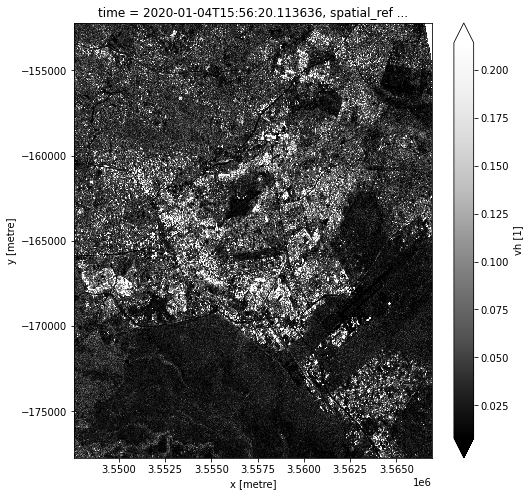

In [9]:
# Plot the first VH observation for the year 2020.
ds.vh.isel(time=0).plot(cmap="Greys_r", robust=True, figsize=(8, 8))

## Apply speckle filtering

Radar observations appear speckly due to random interference of coherent signals from target scatters. 
The speckle noise can be reduced by averaging pixel values over an area or over time. 
However, averaging over a fixed window smoothes out real local spatial variation and leads to reduced spatial resolution.
An adaptive approach that takes into account local homogeneity is therefore preferred.

Below, we apply the Lee filter, one of the popular adaptive speckle filters.

In [10]:
# Defining a function to apply lee filtering on S1 image.
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img ** 2, (size, size))
    img_variance = img_sqr_mean - img_mean ** 2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)

    return img_output

Now that we've defined the filter, we can run it on the VV and VH data. 
You might have noticed that the function takes a size argument. 
This will change how blurred the image becomes after smoothing. 
We've picked a default value for this analysis, but you can experiement with this if you're interested.

### Apply the Lee speckle filter using a window size of 3

In [11]:
# The lee filter above doesn't handle null values.
# We therefore set null values to 0 before applying the filter.
valid = xr.ufuncs.isfinite(ds)
ds = ds.where(valid, 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
ds["filtered_vv"] = ds.vv.groupby("time").apply(lee_filter, size=3)
ds["filtered_vh"] = ds.vh.groupby("time").apply(lee_filter, size=3)

# Null pixels should remain null
ds["filtered_vv"] = ds.filtered_vv.where(valid.vv)
ds["filtered_vh"] = ds.filtered_vh.where(valid.vh)

## Convert the digital numbers (DN) values  to dB scale (logarithmic scale)
While Sentinel-1 backscatter is provided as linear intensiy, it is often useful to convert the backscatter to decible (dB) for analysis. 
Backscatter in dB unit has a more symmetric noise profile and less skewed value distribution for easier statistical evaluation.

In [12]:
ds["filtered_vv"] = 10 * xr.ufuncs.log10(ds.filtered_vv)
ds["filtered_vh"] = 10 * xr.ufuncs.log10(ds.filtered_vh)

## Generate a median value composite image
We will combine all the speckle-filtered VH and VV observations in our Sentinel 1 `ds` `xarray.Dataset` into a single, complete (or near complete) image representing the median of the time period.

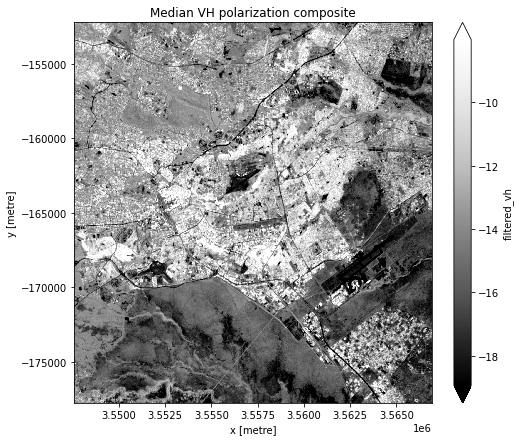

In [13]:
# Obtain the median of all VH observations for the time period.
median_vh = ds.filtered_vh.median(dim="time")

# Plot the median VH polarization composite.
fig = plt.figure(figsize=(8, 7))
median_vh.plot(cmap="Greys_r", robust=True)
plt.title("Median VH polarization composite");

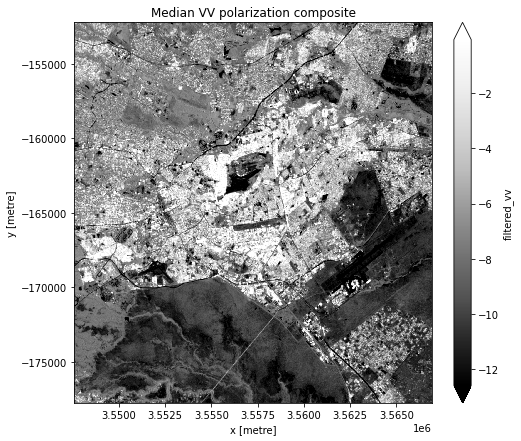

In [14]:
# Obtain the median of all VV observations for the time period.
median_vv = ds.filtered_vv.median(dim="time")

# Plot the median VV polarization composite.
fig = plt.figure(figsize=(8, 7))
median_vv.plot(cmap="Greys_r", robust=True)
plt.title("Median VV polarization composite");

Merge the median VH and VV polarization composites into one dataset. 

In [15]:
# Merge the median VH and VV polarization composite Data Arrays into one dataset.
img = xr.merge([median_vh.rename("median_vh"), median_vv.rename("median_vv")])
print(img)

<xarray.Dataset>
Dimensions:      (y: 2551, x: 1931)
Coordinates:
  * y            (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05 -1.777e+05
  * x            (x) float64 3.548e+06 3.548e+06 ... 3.567e+06 3.567e+06
    spatial_ref  int32 6933
Data variables:
    median_vh    (y, x) float32 -11.1 -11.67 -12.31 ... -17.53 -17.76 -17.88
    median_vv    (y, x) float32 -3.632 -4.258 -5.28 ... -10.72 -10.98 -11.19


## Classification using Otsu thresholding

For classification using thresholding, we will perform the classification separately for the VH polarization median composite and the VV polarization median composite. 

First, we will use the scikit-image `try_all_threshold` function to evaluate different thresholding algorithms in order to select the best threshold algorithm.

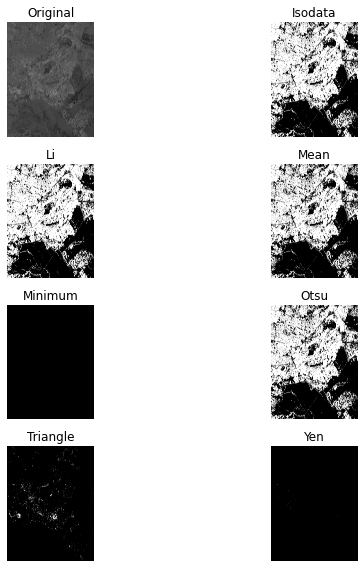

In [16]:
# Convert the VH polarization median composite Data Array into a numpy array.
img_vh = img.median_vh.data

# Apply the try_all_threshold function on the VH polarization median composite numpy array.
fig, ax = try_all_threshold(img_vh, figsize=(10, 8), verbose=False)
plt.show()

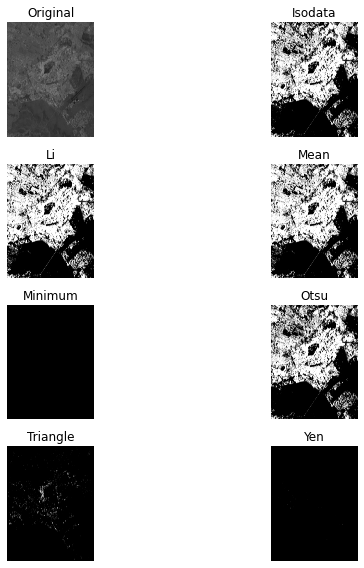

In [17]:
# Convert the VV polarization median composite Data Array into a numpy array.
img_vv = img.median_vv.data

# Apply the try_all_threshold function on the VV polarization median composite numpy array.
fig, ax = try_all_threshold(img_vv, figsize=(10, 8), verbose=False)
plt.show()

From the above plots, the best thresholding algorithm to use for the two median composites is the Otsu thresholding method. 
We will use this method to obtain the threshold values which we will then use to classify our median composites.  

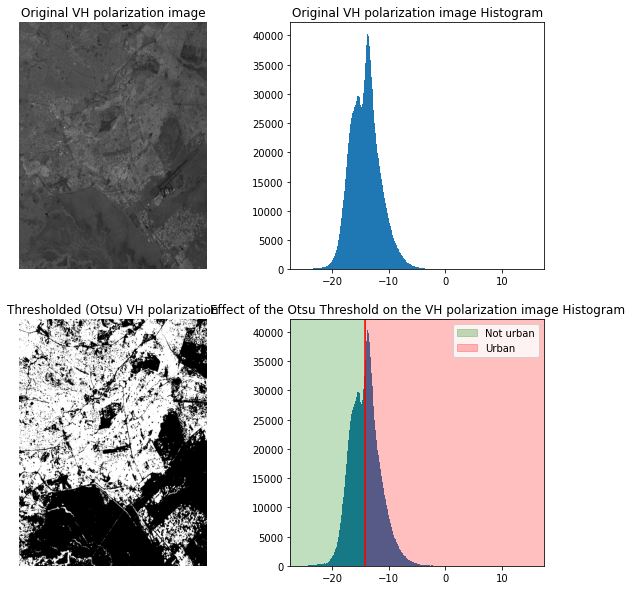

In [18]:
# Define the VH polarization threshold.
thresh_vh = threshold_otsu(img_vh)

# Apply the thresholding.
binary_vh = img_vh > thresh_vh

# Plot the original and classified images with their respective histograms.

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(img_vh, cmap=plt.cm.gray)
ax[0, 0].set_title("Original VH polarization image")

ax[0, 1].hist(img_vh.ravel(), bins=1000)
ax[0, 1].axis(xmin=img_vh.min(), xmax=img_vh.max())
ax[0, 1].set_title("Original VH polarization image Histogram")

ax[1, 0].imshow(binary_vh, cmap=plt.cm.gray)
ax[1, 0].set_title("Thresholded (Otsu) VH polarization")

ax[1, 1].hist(img_vh.ravel(), bins=1000)
ax[1, 1].axis(xmin=img_vh.min(), xmax=img_vh.max())
ax[1, 1].axvspan(
    xmin=img_vh.min(), xmax=thresh_vh, alpha=0.25, color="green", label="Not urban"
)
ax[1, 1].axvspan(
    xmin=thresh_vh, xmax=img_vh.max(), alpha=0.25, color="red", label="Urban"
)
ax[1, 1].axvline(thresh_vh, color="r")
ax[1, 1].set_title(
    "Effect of the Otsu Threshold on the VH polarization image Histogram"
)

for a in ax[:, 0]:
    a.axis("off")
    plt.legend()
plt.show()

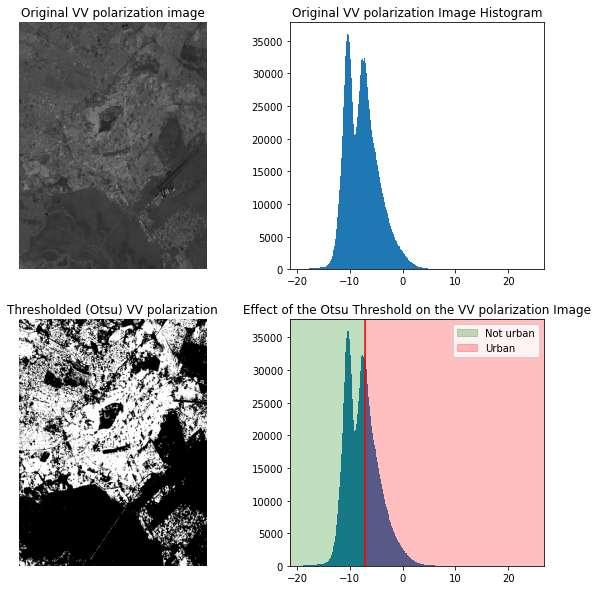

In [19]:
# Define the VV polarization threshold.
thresh_vv = threshold_otsu(img_vv)

# Apply the thresholding.
binary_vv = img_vv > thresh_vv

# Plot the original and classified images with their respective histograms.

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(img_vv, cmap=plt.cm.gray)
ax[0, 0].set_title("Original VV polarization image")

ax[0, 1].hist(img_vv.ravel(), bins=1000)
ax[0, 1].axis(xmin=img_vv.min(), xmax=img_vv.max())
ax[0, 1].set_title("Original VV polarization Image Histogram")

ax[1, 0].imshow(binary_vv, cmap=plt.cm.gray)
ax[1, 0].set_title("Thresholded (Otsu) VV polarization")

ax[1, 1].hist(img_vv.ravel(), bins=1000)
ax[1, 1].axis(xmin=img_vv.min(), xmax=img_vv.max())
ax[1, 1].axvspan(
    xmin=img_vv.min(), xmax=thresh_vv, alpha=0.25, color="green", label="Not urban"
)
ax[1, 1].axvspan(
    xmin=thresh_vv, xmax=img_vv.max(), alpha=0.25, color="red", label="Urban"
)
ax[1, 1].axvline(thresh_vv, color="r")
ax[1, 1].set_title("Effect of the Otsu Threshold on the VV polarization Image")

for a in ax[:, 0]:
    a.axis("off")
    plt.legend()
plt.show()

In [20]:
# Convert the binary_vh and binary_vv numpy arrays into an xarray Dataset.
thresholding_predicted_ds = xr.Dataset(
    data_vars=dict(
        thresholding_predicted_vh=(["y", "x"], binary_vh),
        thresholding_predicted_vv=(["y", "x"], binary_vv),
    ),
    coords=dict(
        y=(["y"], img.coords["y"].values),
        x=(["x"], img.coords["x"].values),
        spatial_ref=img.coords["spatial_ref"].values,
    ),
    attrs=img.attrs,
)

print(thresholding_predicted_ds)

<xarray.Dataset>
Dimensions:                    (y: 2551, x: 1931)
Coordinates:
  * y                          (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05
  * x                          (x) float64 3.548e+06 3.548e+06 ... 3.567e+06
    spatial_ref                int32 6933
Data variables:
    thresholding_predicted_vh  (y, x) bool True True True ... False False False
    thresholding_predicted_vv  (y, x) bool True True True ... False False False


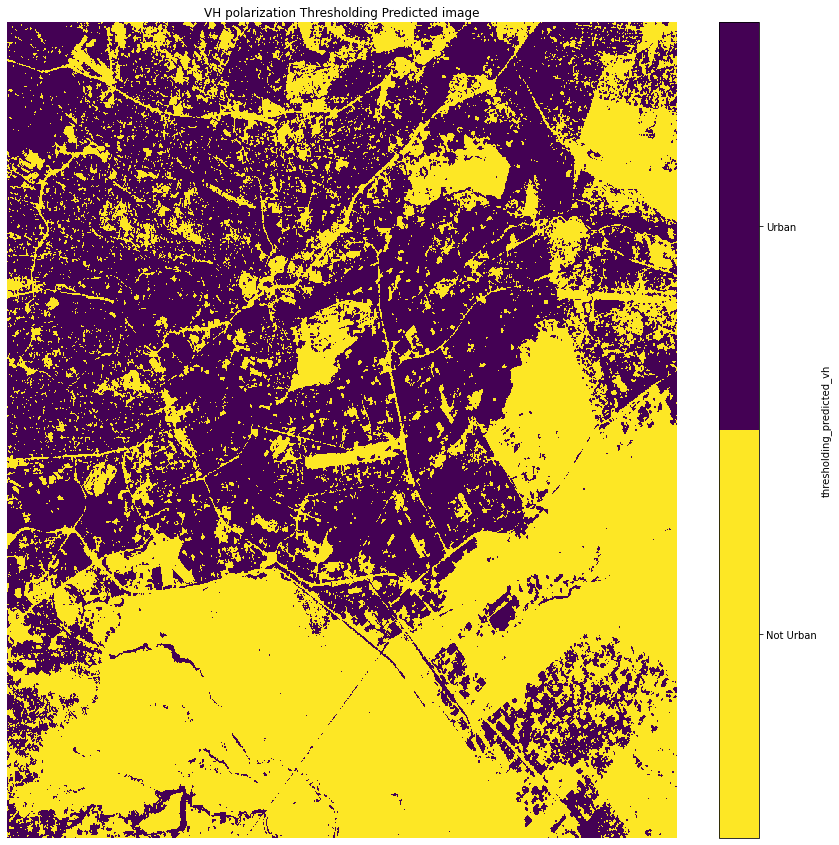

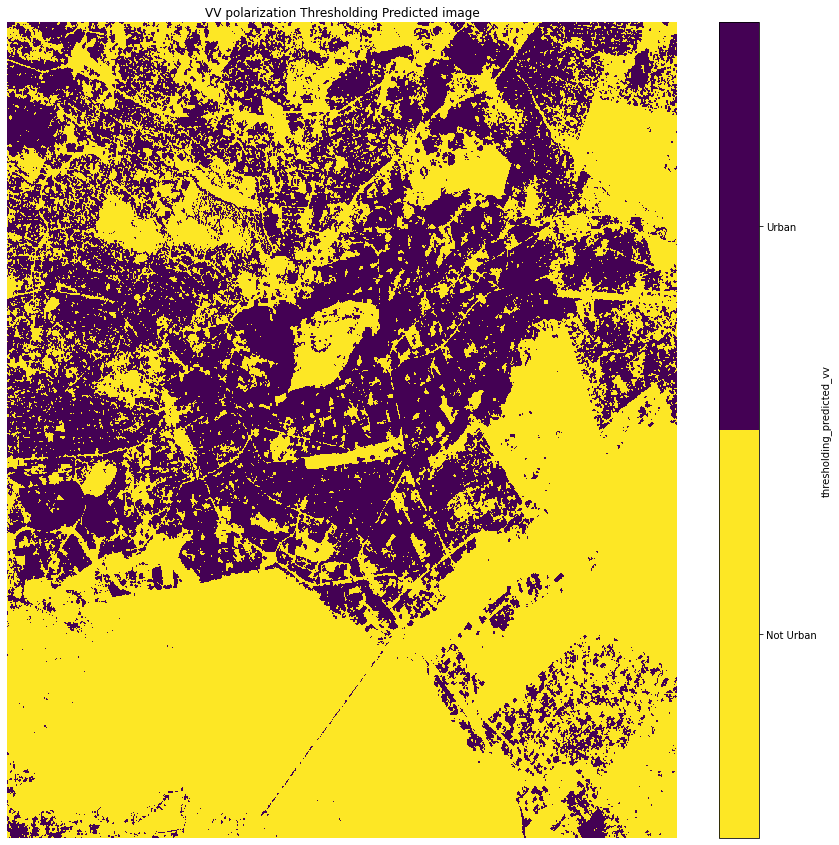

In [21]:
# Plot the thresholding_predicted_ds Dataset.
band_list = list(thresholding_predicted_ds.data_vars)

for band in band_list:
    if "vh" in band:
        title = "VH polarization Thresholding Predicted image"
    else:
        title = "VV polarization Thresholding Predicted image"

    image = thresholding_predicted_ds[band]
    no_classes = 2
    bounds = range(0, no_classes + 1)
    colour_list = ["#fde725", "#440154"]
    cmap = mcolours.ListedColormap(colour_list)
    bounds = range(0, no_classes + 1)
    norm = mcolours.BoundaryNorm(np.array(bounds), cmap.N)
    cblabels = ["Not Urban", "Urban"]
    im = image.plot.imshow(cmap=cmap, norm=norm, add_colorbar=True, figsize=(15, 15))
    cb = im.colorbar
    cb.set_ticks(np.arange(0, no_classes + 1, 1) + 0.5)
    cb.set_ticklabels(cblabels)
    plt.axis("off")
    plt.title(title)
    plt.show()

## Classification using Kmeans Clustering

In the next cell we will create a set of functions which will together be used to perform Kmeans Clustering on our median value composite image. 
This functions are adapted from the ones used [here](https://ml-gis-service.com/index.php/2020/10/14/data-science-unsupervised-classification-of-satellite-images-with-k-means-algorithm/).

In [22]:
# Defining functions to use for in the clustering.


def raster_stack(input_xr):
    """
    Reshape a DataArray or Dataset with spatial structure spatial (and optionally
    temporal) structure into a numpy array with the spatial and optional temporal
    dimensions flattened into one dimension.

    This flattening procedure enables DataArrays and Datasets to be used
    to train and predict with sklearn models.

    Last modified: November 2021

    Parameters
    ----------
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.
        Dimensions other than 'x', 'y' and 'time' are unaffected by the
        flattening.

    Returns
    ----------
    input_np : numpy.array
        A numpy array corresponding to input_xr.data (or
        input_xr.to_array().data), with dimensions 'x','y' and 'time'
        flattened into a single dimension, which is the first axis of
        the returned array.
    """
    # Cast input DataArrays to Dataset.
    if isinstance(input_xr, xr.DataArray):
        input_xr = input_xr.to_dataset()

    # Get the data type for the input_xr Dataset data values.
    data_type = input_xr.to_array().data.dtype

    # Get the number of bands in the input_xr Dataset.
    bands_list = list(input_xr.data_vars)
    nbands = len(bands_list)
    # Create a dictionary of the bands and their index in the list bands_list.
    bands_dict = {k: v for k, v in enumerate(bands_list)}

    # Get the dimensions x and y of the input_xr Dataset.
    height = input_xr.dims["y"]
    width = input_xr.dims["x"]

    # Get the dimension time of the input_xr Dataset.
    # Create an empty numpy array, model_input, in which each column will hold a
    # flattened band/measurement from the input_xr Dataset.
    if "time" in input_xr.dims:
        time = input_xr.dims["time"]
        model_input = np.empty((height * width * time, nbands), dtype=data_type)
    else:
        model_input = np.empty((height * width, nbands), dtype=data_type)

    # Loop through each band in the input_xr Dataset and add it
    # to the numpy array model_input.
    for i, band in bands_dict.items():
        band_array = np.array(input_xr[band])
        model_input[:, i - 1] = band_array.flatten()

    return model_input


def raster_unstack(output_np, input_xr):
    """
    Reshape a numpy array with no 'missing' elements (NaNs) and
    'flattened' spatiotemporal structure into a DataArray matching the
    spatiotemporal structure of the DataArray

    This enables an sklearn model's prediction to be remapped to the
    correct pixels in the input DataArray or Dataset.

    Last modified: September 2019

    Parameters
    ----------
    output_np : numpy.array
        The first dimension's length should correspond to the number of
        valid (non-NaN) pixels in input_xr.
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.
        Dimensions other than 'x', 'y' and 'time' are unaffected by the
        flattening.

    Returns
    ----------
    output_xr : xarray.DataArray
        An xarray.DataArray with the same dimensions 'x', 'y' and 'time'
        as input_xr, and the same valid (non-NaN) pixels. These pixels
        are set to match the data in output_np.

    """
    # The  expected output of a sklearn model prediction
    # should just be a 1 dimensional numpy array, output_np, with the
    # size/columns matching the height * width * time  for the
    # dimensions of the input_xr DataArray/Dataset.

    # Cast the input DataArray to Dataset.
    if isinstance(input_xr, xr.DataArray):
        input_xr = input_xr.to_dataset()

    # Get the data type for the input_xr Dataset.
    data_type = input_xr.to_array().data.dtype

    # Get the dimensions x , y of the input_xr Dataset.
    height = input_xr.dims["y"]
    width = input_xr.dims["x"]

    # Get the dimension time of the input_xr Dataset.
    if "time" in input_xr.dims:
        time = input_xr.dims["time"]
        # Reshape the output_np numpy array.
        output_np = output_np.reshape((time, height, width))
        # Convert the output_np numpy array into a xarray Dataset.
        output_np_ds = xr.Dataset(
            data_vars=dict(clustering_predicted=(["time", "y", "x"], output_np)),
            coords=dict(
                time=(["time"], input_xr.coords["time"].values),
                y=(["y"], input_xr.coords["y"].values),
                x=(["x"], input_xr.coords["x"].values),
                spatial_ref=input_xr.coords["spatial_ref"].values,
            ),
            attrs=input_xr.attrs,
        )
    else:
        # Reshape the output_np numpy array.
        output_np = output_np.reshape((height, width))
        # Convert the output_np numpy array into a xarray Dataset.
        output_np_ds = xr.Dataset(
            data_vars=dict(clustering_predicted=(["y", "x"], output_np)),
            coords=dict(
                y=(["y"], input_xr.coords["y"].values),
                x=(["x"], input_xr.coords["x"].values),
                spatial_ref=input_xr.coords["spatial_ref"].values,
            ),
            attrs=input_xr.attrs,
        )

    return output_np_ds


def show_clustered(predicted_ds):
    """
    Takes the predicted xarray dataset and plots it using the
    clustering_predicted band.

    Last modified: November 2021
    Parameters
    ----------
    predicted_ds : xarray Dataset
    The xarray dataset which is the result of the kmeans clustering.

    Returns
    -------
    An plot of the classification band of the predicted_ds.
    """
    # Display predicted_ds Dataset with upto 6 unique classes.
    image = predicted_ds.clustering_predicted

    # Color list with 6 colors from the virdis color map.
    no_classes = len(np.unique(image))
    colour_list = ["#fde725", "#440154", "#22a884", "#414487", "#2a788e", "#7ad151"]
    colours = colour_list[:no_classes]
    cmap = mcolours.ListedColormap(colours)
    bounds = range(0, no_classes + 1)
    norm = mcolours.BoundaryNorm(np.array(bounds), cmap.N)
    cblabels = [str(i) for i in bounds]
    im = image.plot.imshow(cmap=cmap, norm=norm, add_colorbar=True, figsize=(15, 15))
    cb = im.colorbar
    cb.set_ticks(np.arange(0, no_classes + 1, 1) + 0.5)
    cb.set_ticklabels(cblabels)
    plt.axis("off")
    title = f"Kmeans Clustering Predicted Image using {no_classes} clusters"
    plt.title(title)
    plt.show()


def kmeans_clustering(input_xr, cluster_range):
    """
    Perform sklearn Kmeans clustering on the input Dataset
    or Data Array.

    Last modified: November 2021

    Parameters
    ----------
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.

    cluster_range : list
        A list of the number of clusters to use to perform the Kmeans clustering
        on the input_xr Dataset.

    Returns
    ----------
    results : dictionary
        A dictionary with the number of clusters as keys and the predicted datasets as
        the values. Each predicted dataset is an xarray.Dataset with the same dimensions
        'x', 'y' and 'time' as the input_xr.

    """

    # Use the raster_stack function to convert the Dataset into a 2 dimensional numpy array.
    model_input = raster_stack(input_xr)

    # Imputations: replace the np.nan values or np.inf values with 0.
    model_input = np.nan_to_num(model_input, nan=0, posinf=0, neginf=0)

    # Due to the large variation in the magnitude of the VH an VV polarization
    # standardize the data.
    scaler = StandardScaler()
    model_input = scaler.fit_transform(model_input)

    # Dictionary to save results
    results = {}

    # Perform Kmeans clustering on the input dataset for each number of clusters
    # in the cluster_range list.
    for no_of_clusters in cluster_range:
        # Set up the kmeans classification by specifying the number of clusters
        # with initialization as k-means++.
        km = KMeans(n_clusters=no_of_clusters, init="k-means++")

        # Begin iteratively computing the position of the clusters.
        km.fit(model_input)

        # Use the sklearn kmeans .predict method to assign all the pixels of the
        # model input to a unique cluster.
        flat_predictions = km.predict(model_input)

        # Use the raster_unstack function to convert the flat predictions into a
        # xarray Dataset.
        predicted = raster_unstack(flat_predictions, input_xr)

        # Append the results to a dictionary using the number of clusters as the
        # column as an key.
        results.update({str(no_of_clusters): predicted})

    return results

In the next cell, we will use a range of clusters to perform  K-means classification on our median composite dataset.

In [23]:
cluster_range = [2, 3, 4]
results = kmeans_clustering(img, cluster_range)
results

{'2': <xarray.Dataset>
 Dimensions:               (y: 2551, x: 1931)
 Coordinates:
   * y                     (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05
   * x                     (x) float64 3.548e+06 3.548e+06 ... 3.567e+06
     spatial_ref           int32 6933
 Data variables:
     clustering_predicted  (y, x) int32 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0,
 '3': <xarray.Dataset>
 Dimensions:               (y: 2551, x: 1931)
 Coordinates:
   * y                     (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05
   * x                     (x) float64 3.548e+06 3.548e+06 ... 3.567e+06
     spatial_ref           int32 6933
 Data variables:
     clustering_predicted  (y, x) int32 0 0 2 2 2 0 0 0 0 2 ... 1 1 1 1 1 1 1 1 1,
 '4': <xarray.Dataset>
 Dimensions:               (y: 2551, x: 1931)
 Coordinates:
   * y                     (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05
   * x                     (x) float64 3.548e+06 3.548e+06 ... 3.567e+06
     spatial_ref           i

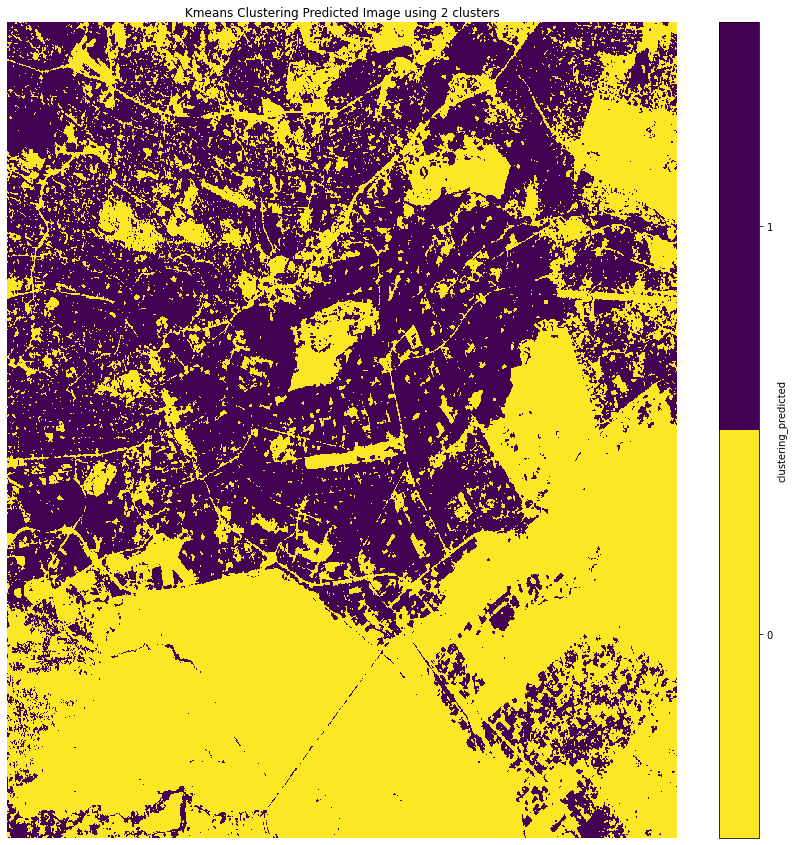

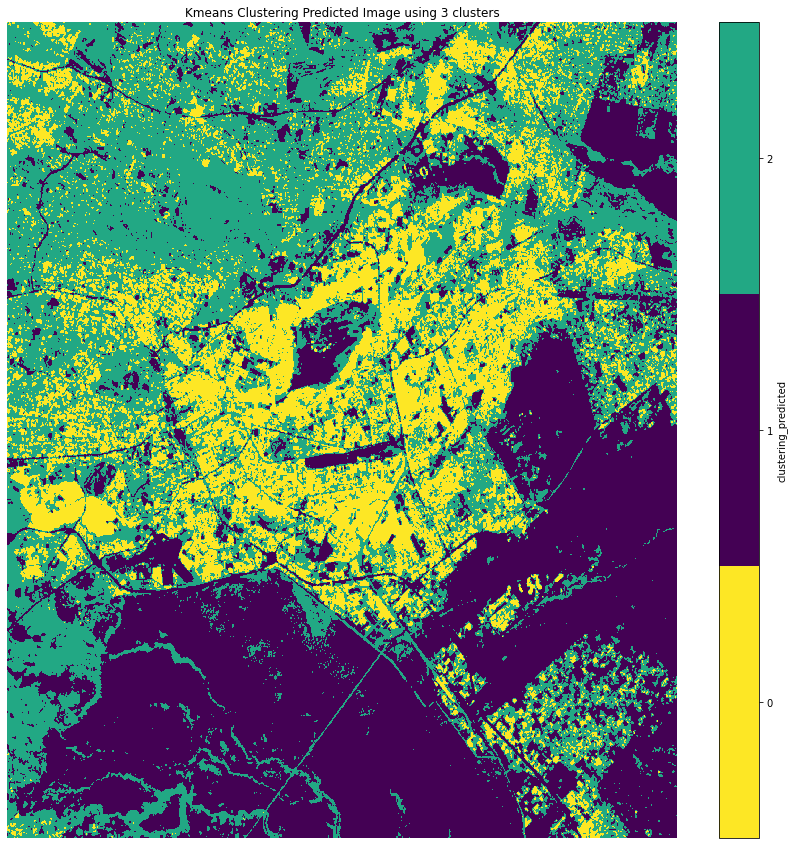

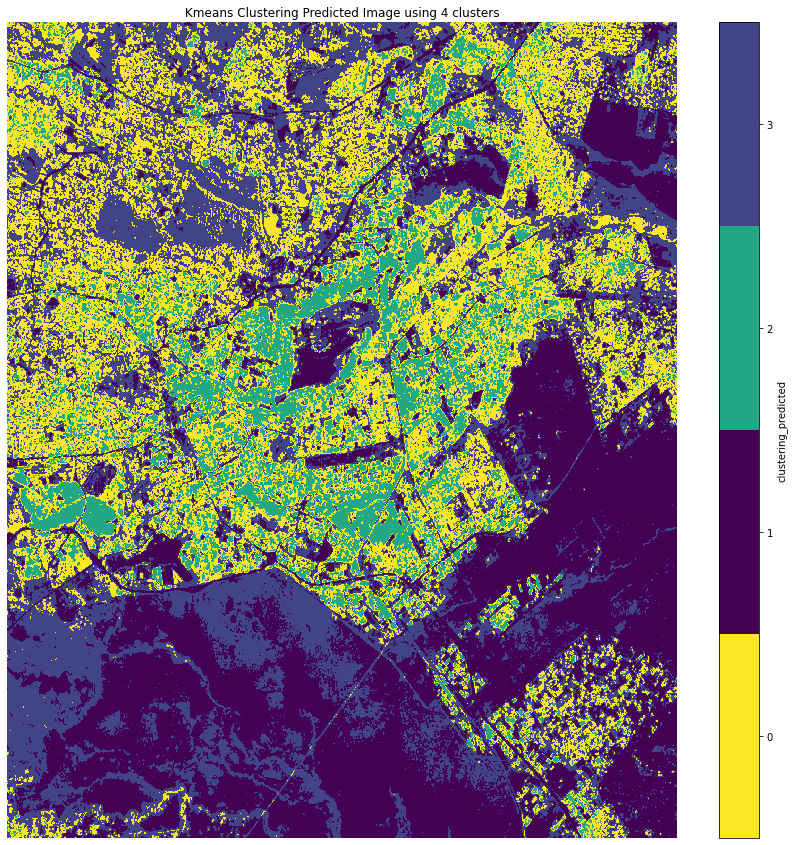

In [24]:
# Plot each of the predicted images.
for predicted_ds in results.values():
    show_clustered(predicted_ds)

From the plotted predicted images above the best number of clusters to use is `3` clusters. 
In this image, the most likely pixel value to represent the urban/buit up land cover class is the pixel value `0`. 

In [25]:
# Mask the dataset to retain the pixels which are most likely to be urban/built up.
key = "3"
pixel_value = 0
clustering_predicted_ds = results[key] == pixel_value
print(clustering_predicted_ds)

<xarray.Dataset>
Dimensions:               (y: 2551, x: 1931)
Coordinates:
  * y                     (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05
  * x                     (x) float64 3.548e+06 3.548e+06 ... 3.567e+06
    spatial_ref           int32 6933
Data variables:
    clustering_predicted  (y, x) bool True True False ... False False False


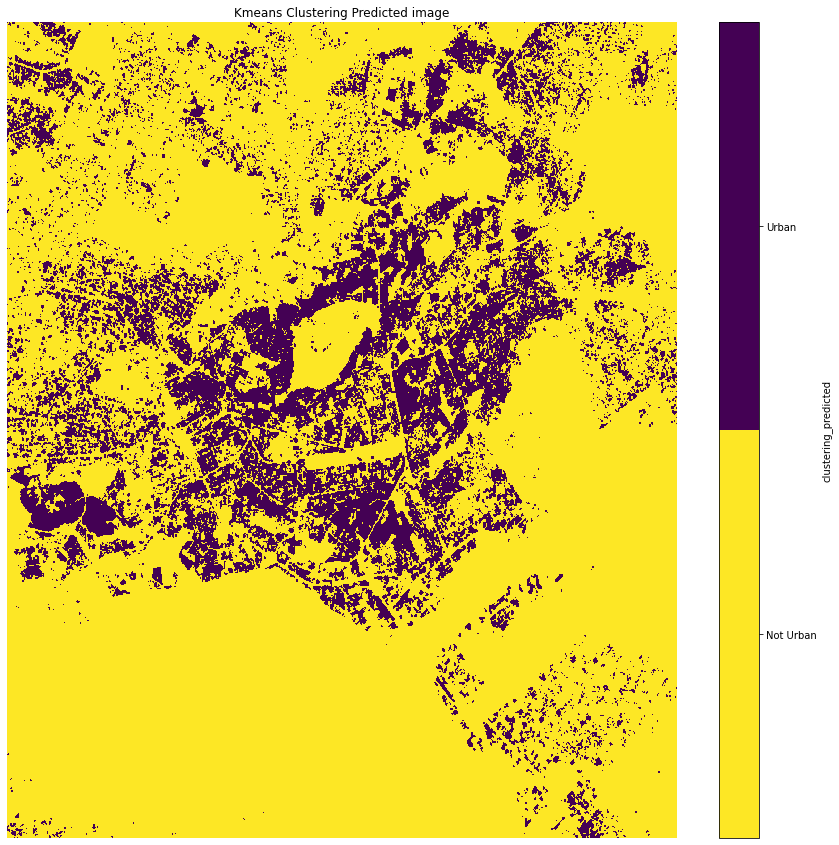

In [26]:
# Plot the clustering_predicted_ds Dataset.
image = clustering_predicted_ds.clustering_predicted
no_classes = 2
colour_list = ["#fde725", "#440154"]
cmap = mcolours.ListedColormap(colour_list)
bounds = range(0, no_classes + 1)
norm = mcolours.BoundaryNorm(np.array(bounds), cmap.N)
cblabels = ["Not Urban", "Urban"]
im = image.plot.imshow(cmap=cmap, norm=norm, add_colorbar=True, figsize=(15, 15))
cb = im.colorbar
cb.set_ticks(np.arange(0, no_classes + 1, 1) + 0.5)
cb.set_ticklabels(cblabels)
plt.axis("off")
plt.title("Kmeans Clustering Predicted image")
plt.show()

## Validation of the classifications
We will compare the performance of the urban area Kmeans clustering and Otsu thresholding classification results against a built area (urban area) map for the study area derived from the ESA World Cover, global 10 m land use/land cover data from 2020. 

### Obtain the validation dataset

In [27]:
# Load the ESA land use land cover product over the same region as the Sentinel 1 dataset.
ds_esa = dc.load(product="esa_worldcover", like=ds.geobox).squeeze()

print(ds_esa)

<xarray.Dataset>
Dimensions:         (y: 2551, x: 1931)
Coordinates:
    time            datetime64[ns] 2020-07-01T12:00:00
  * y               (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05 -1.777e+05
  * x               (x) float64 3.548e+06 3.548e+06 ... 3.567e+06 3.567e+06
    spatial_ref     int32 6933
Data variables:
    classification  (y, x) uint8 10 10 10 20 10 10 60 ... 30 30 30 30 30 30 30
Attributes:
    crs:           PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 8...
    grid_mapping:  spatial_ref


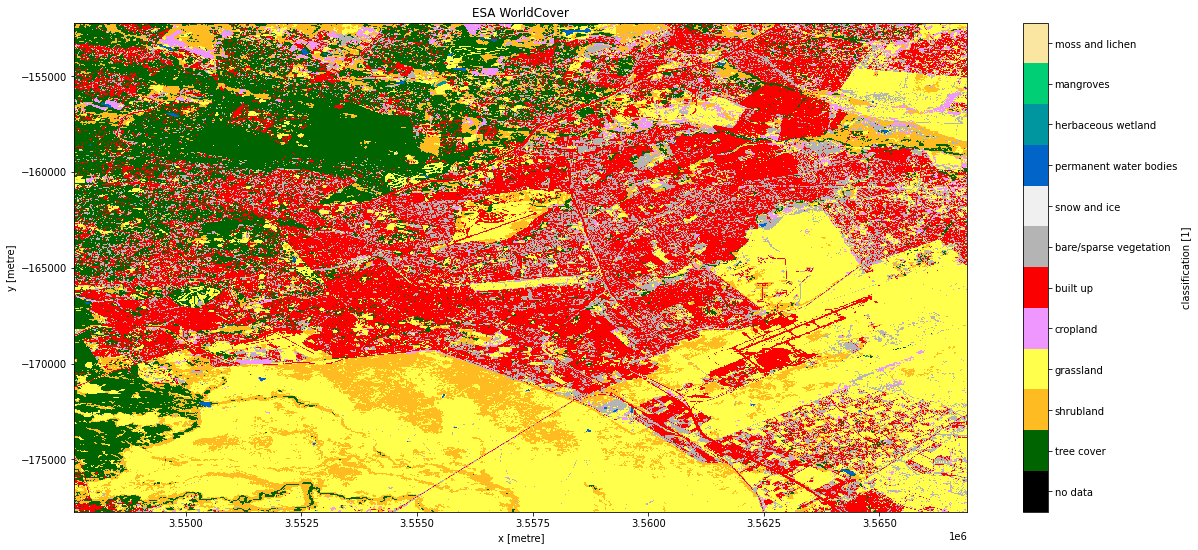

In [28]:
# Plot the ESA land use land cover product.
fig, ax = plt.subplots(figsize=(20, 9), sharey=True)
plot_lulc(ds_esa["classification"], product="ESA", legend=True, ax=ax)
plt.title("ESA WorldCover");

In [29]:
# Get the pixel value for each land cover class represented in the esa dataset.
dc_measurements = dc.list_measurements()
esa_lulc_measurements = dc_measurements.loc[["esa_worldcover"]]
esa_lulc_measurements.loc["esa_worldcover", "classification"].flags_definition

{'data': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'no data',
   '10': 'tree cover',
   '20': 'shrubland',
   '30': 'grassland',
   '40': 'cropland',
   '50': 'built up',
   '60': 'bare/sparse vegetation',
   '70': 'snow and ice',
   '80': 'permanent water bodies',
   '90': 'herbaceous wetland',
   '95': 'mangroves',
   '100': 'moss and lichen'},
  'description': 'Land Use/Land Cover class'}}

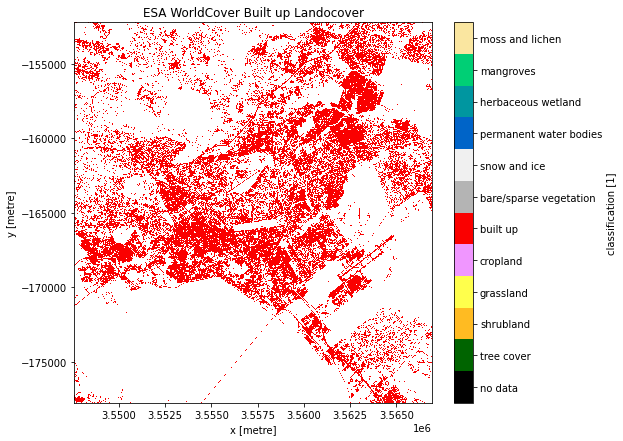

In [30]:
# Plot the built up land cover from the ESA worldcover dataset.
built_up = ds_esa.where(ds_esa["classification"] == 50)
plot_lulc(built_up["classification"], product="ESA", legend=True, figsize=(8, 7))
plt.title("ESA WorldCover Built up Landocover");

In [31]:
# Pixels with a value of 50 are classified as built up land cover.
# Mask the ESA land cover dataset to retain only pixels with the value 50.
actual = ds_esa["classification"] == 50
print(actual)

<xarray.DataArray 'classification' (y: 2551, x: 1931)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    time         datetime64[ns] 2020-07-01T12:00:00
  * y            (y) float64 -1.522e+05 -1.522e+05 ... -1.777e+05 -1.777e+05
  * x            (x) float64 3.548e+06 3.548e+06 ... 3.567e+06 3.567e+06
    spatial_ref  int32 6933


### Metric and Plotting Functions
The code below will calculate the true/false positive/negative sums and calculate values for a typical confusion matrix to assess the results. 
This code is adapted from [Urban index comparison](Urban_index_comparison.ipynb). 
Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. 

$$
\begin{aligned}
\text{Accuracy} = \frac{\text{True Positive} + \text{True Negative}}{\text{Total Pixels}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Precision} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}
\end{aligned}
$$

$$
\begin{aligned}
\text{F1 Score} = 2*\frac{\text{Recall}*\text{Precision}}{\text{Recall} + \text{Precision}}
\end{aligned}
$$

In [32]:
def get_metrics(actual, predicted, filter_size=1):
    """Creates performance metrics.

    Args:
        actual: the data to use as truth.
        predicted: the data to predict and to compare against actual.
        filter_size: the filter size to apply on predicted to remove small object/holes with.

    Returns: A namedtuple containing the actual, predicted mask, and varying metrics for a confusion matrix.
    """
    metrics = namedtuple(
        "Metrics",
        "actual predicted true_positive true_negative false_positive false_negative",
    )

    predicted = remove_small_objects(
        predicted, min_size=filter_size + 1, connectivity=2
    )
    predicted = remove_small_holes(
        predicted, area_threshold=filter_size + 1, connectivity=2
    )

    true_positive = (predicted & actual).sum()
    true_negative = (~predicted & ~actual).sum()
    false_positive = (predicted & ~actual).sum()
    false_negative = (~predicted & actual).sum()

    return metrics(
        actual=actual,
        predicted=predicted,
        true_positive=true_positive,
        true_negative=true_negative,
        false_positive=false_positive,
        false_negative=false_negative,
    )


def print_metrics(metrics):
    norm = (
        metrics.true_positive
        + metrics.false_negative
        + metrics.false_positive
        + metrics.true_negative
    )
    accuracy = (metrics.true_positive + metrics.true_negative) / norm
    ppv = metrics.true_positive / (metrics.true_positive + metrics.false_positive)
    tpr = metrics.true_positive / (metrics.true_positive + metrics.false_negative)
    f1 = (2 * ppv * tpr) / (ppv + tpr)

    print(
        "True Positive (Actual + Model = Urban): {tp}".format(
            tp=round(metrics.true_positive / norm * 100, 3)
        )
    )
    print(
        "True Negative (Actual + Model = Non-Urban): {tn}".format(
            tn=round(metrics.true_negative / norm * 100, 3)
        )
    )
    print(
        "False Positive (Actual=Non-Urban, Model=Urban): {fp}".format(
            fp=round(metrics.false_positive / norm * 100, 3)
        )
    )
    print(
        "False Negative (Actual=Urban, Model=Non-Urban): {fn}".format(
            fn=round(metrics.false_negative / norm * 100, 3)
        )
    )
    print("\nAccuracy: {accuracy}".format(accuracy=round(accuracy * 100, 3)))
    print("F1 Score: {f1}\n".format(f1=round(f1 * 100, 3)))

In [33]:
# Print the metrics for the Kmeans Clustering.
print(
    "\033[1m" + "\033[91m" + "Urban Area Mapping Kmeans Clustering Results"
)  # bold print and red
print("\033[0m")  # stop bold and red
metrics_clustering = get_metrics(
    actual.values, clustering_predicted_ds.clustering_predicted.values
)
print_metrics(metrics_clustering)

# Print the metrics for the Otsu Thresholding using VH polarization.
print(
    "\033[1m"
    + "\033[91m"
    + "Urban Area Mapping Otsu Thresholding using VH polarization Results"
)  # bold print and red
print("\033[0m")  # stop bold and red
metrics_thresh_vh = get_metrics(
    actual.values, thresholding_predicted_ds.thresholding_predicted_vh.values
)
print_metrics(metrics_thresh_vh)

# Print the metrics for the Otsu Thresholding using VV polarization.
print(
    "\033[1m"
    + "\033[91m"
    + "Urban Area Mapping Otsu Thresholding using VV polarization Results"
)  # bold print and red
print("\033[0m")  # stop bold and red
metrics_thresh_vv = get_metrics(
    actual.values, thresholding_predicted_ds.thresholding_predicted_vv.values
)
print_metrics(metrics_thresh_vv)

Urban Area Mapping Kmeans Clustering Results

True Positive (Actual + Model = Urban): 13.673
True Negative (Actual + Model = Non-Urban): 66.796
False Positive (Actual=Non-Urban, Model=Urban): 6.666
False Negative (Actual=Urban, Model=Non-Urban): 12.865

Accuracy: 80.469
F1 Score: 58.335

Urban Area Mapping Otsu Thresholding using VH polarization Results

True Positive (Actual + Model = Urban): 21.546
True Negative (Actual + Model = Non-Urban): 44.698
False Positive (Actual=Non-Urban, Model=Urban): 28.763
False Negative (Actual=Urban, Model=Non-Urban): 4.992

Accuracy: 66.244
F1 Score: 56.074

Urban Area Mapping Otsu Thresholding using VV polarization Results

True Positive (Actual + Model = Urban): 20.67
True Negative (Actual + Model = Non-Urban): 53.632
False Positive (Actual=Non-Urban, Model=Urban): 19.83
False Negative (Actual=Urban, Model=Non-Urban): 5.869

Accuracy: 74.302
F1 Score: 61.666



The `dstack` calls provide the `imshow` calls with RGB array inputs. 
For the plotted image, the first channel (red) is the actual (ground truth, ESA Worldcover) values, and both the second and third channels (green, blue) are the predicted values (green + blue = cyan).

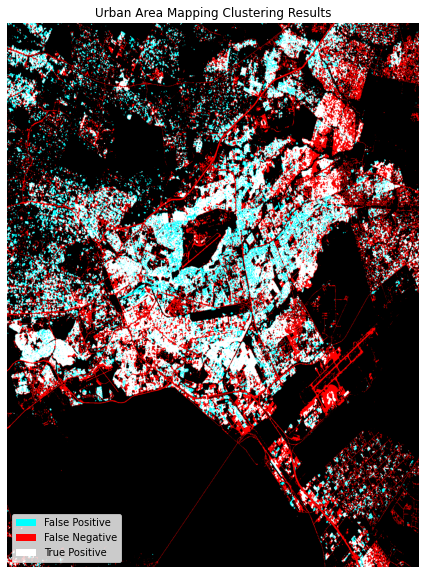

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(
    np.dstack(
        (
            metrics_clustering.actual.astype(float),
            metrics_clustering.predicted.astype(float),
            metrics_clustering.predicted.astype(float),
        )
    )
)
plt.legend(
    [Patch(facecolor="cyan"), Patch(facecolor="red"), Patch(facecolor="white")],
    ["False Positive", "False Negative", "True Positive"],
    loc="lower left",
    fontsize=10,
)
plt.axis("off")
plt.title("Urban Area Mapping Clustering Results");

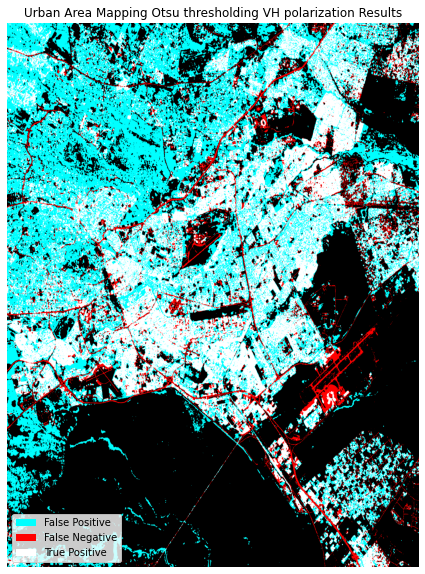

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(
    np.dstack(
        (
            metrics_thresh_vh.actual.astype(float),
            metrics_thresh_vh.predicted.astype(float),
            metrics_thresh_vh.predicted.astype(float),
        )
    )
)
plt.legend(
    [Patch(facecolor="cyan"), Patch(facecolor="red"), Patch(facecolor="white")],
    ["False Positive", "False Negative", "True Positive"],
    loc="lower left",
    fontsize=10,
)
plt.axis("off")
plt.title("Urban Area Mapping Otsu thresholding VH polarization Results");

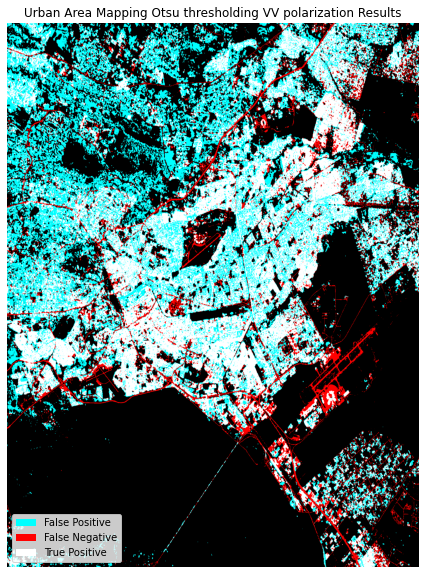

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(
    np.dstack(
        (
            metrics_thresh_vv.actual.astype(float),
            metrics_thresh_vv.predicted.astype(float),
            metrics_thresh_vv.predicted.astype(float),
        )
    )
)
plt.legend(
    [Patch(facecolor="cyan"), Patch(facecolor="red"), Patch(facecolor="white")],
    ["False Positive", "False Negative", "True Positive"],
    loc="lower left",
    fontsize=10,
)
plt.axis("off")
plt.title("Urban Area Mapping Otsu thresholding VV polarization Results");

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [37]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [38]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-11-15'